# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile

from PIL import Image, ImageDraw
import pytesseract
import cv2
import numpy

# loading the face detection classifier
face_cascade = cv2.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!

In [2]:
from kraken import pageseg
from datetime import datetime
import string
import math
from IPython.utils import io


MAX_SIZE = (85, 85)


def extract_from_zip(zip_path, save_path):
    """
    Return a dictionary of the extracted files from the ZIP file path
    
    :param zip_path: string file path to a zip file
    :param save_path: string file path to directory of extracted files
    :return dicts: list of dictionaries for the extracted files, with:
        {name: file name,
        filepath: file path,
        img_pil: PIL.Image object of the image, in grayscale
    """

    print(f'\tRunning Function: extract_from_zip ({datetime.now().time()})')
    dicts = []
    with zipfile.ZipFile(zip_path, mode='r') as myzip:
        myzip.extractall(save_path)
        for file in myzip.infolist():
            d = {'name': file.filename, 'filepath': save_path + file.filename}
            d['img_pil'] = Image.open(d['filepath']).convert('L')
            dicts.append(d)
    return dicts


def process_image(img, img_type='PIL', timeit=True):
    """
    Accepts an image, processes it, and returns a copy as a numpy array

    :param img: either a PIL image or a numpy array image
    :return imcv: the processed image as a numpy array
    """

    if img_type == 'PIL':
        imcv = numpy.array(img)
    elif img_type == 'arr':
        imcv = img.copy()
    else:
        print("ERROR :param img_type: for process_image must be PIL or arr.")
        print("process_image will exit without processing.")
        return
    imcv = binarize(imcv, thresh=177, timeit=timeit)
    imcv = cv2.resize(imcv, None, fx=1.75, fy=1.75, interpolation=cv2.INTER_CUBIC)
    kernel = numpy.ones((1, 1), numpy.uint8)
    imcv = cv2.dilate(imcv, kernel, iterations=1)
    imcv = cv2.erode(imcv, kernel, iterations=1)
    return imcv


def binarize(img_arr, thresh=177, timeit=True):
    """
    :param img: an ndarray image
    :param thresh: thresshold for binzarization (0 to 255)
    :return out_img: the binarized image as an ndarray
    """
    if timeit:
        startb = datetime.now()
        print(f"\t\tStarting Function: binarize ({startb.time()})")
    height, width = img_arr.shape
    out_arr = numpy.zeros((height, width))
    for x in range(width):
        for y in range(height):
            if img_arr[y][x] > thresh:
                out_arr[y][x] = 255
    
    if timeit:
        endb = datetime.now()
        print(f'\t\tFunction Complete: binarize. Time elapsed: {endb - startb}')
    return out_arr


def get_text(d):
    """
    Use Pytesseract to read the text from the text boxes and the text to d
    
    :param d: a dictionary with the image name boxes
    :side effect: add the following information to the dictionary
        'text-boxes': a list of the text read from each text box
        'crop_box_pils': a list of PIL images of each text box
    """

    start = datetime.now()
    print(f"\t\tStarting Function: get_text ({d['name']}) ({start.time()})")
    text_boxes = []
    crop_box_pils = []
    for box in d['boxes']:
        crop_box_arr = d['img_proc_arr'][box[1]:box[3], box[0]:box[2]]
        crop_box_arr = process_image(crop_box_arr, img_type="arr", timeit=False)
        crop_box_pil = Image.fromarray(crop_box_arr).convert('1')
        crop_box_pils.append(crop_box_pil)
        new_text = pytesseract.image_to_string(crop_box_pil)
        new_text = new_text.lower()
        text_boxes.append(new_text)
    d['text_boxes'] = text_boxes
    d['crop_box_pils'] = crop_box_pils
    end = datetime.now()
    print(f'\t\tFunction Complete: get_text. Time elapsed: {end - start}')
    
    
def get_faces_for_target_found(zip_args, target_word: str):
    """
    Search images within a ZIP file for a target word, and extract faces from the pages.
    
    :param zip_args: list with 0: file path for ZIP file, 1: location to save images
    :param target_word: string: the word to be searched
    :return page_dicts: a list of dictionaries with the following information
        'name': the name of the image
        'filepath': the filepath of the image, as extracted from the ZIP file
        'img_pil': a PIL image of the original image
        'img_proc_arr': the processed image as an ndarray
        'img_proc_pil': the processed image as a PIL image
        'boxes': the boxes identified by Kraken
        'text_boxes': a list of the text read from each box identified by Kraken
        'crop_box_pils': a list of the cropped PIL image of each box identified by Kraken
        'text': a single string of the combined text from all boxes, without spaces
        'target_found': a boolean indicating if the target word was found in the image
        'face_images': a list of thumbnails of all faces found on the page
        'contact_sheet': a contact sheet of the thumbnail images of all faces found on the page
    """
    
    # Start Timer
    start_main = datetime.now()
    print(f"Execution Beginning: ({start_main.time()})")
    
    # Extract images from ZIP file and create a dictionary of the images
    page_dicts = extract_from_zip(*zip_args)

    # Loop through each dictionary to read text on the image
    for page_dict in page_dicts:
        
        # Start Timer
        start_d = datetime.now()
        print(f"\tCurrent Image: {page_dict['name']} ({start_d.time()})")

        # --- Pre-process the Newspaper Image ---
        page_dict['img_proc_arr'] = process_image(page_dict['img_pil'])
        page_dict['img_proc_pil'] = Image.fromarray(page_dict['img_proc_arr']).convert('1')

        # --- Kraken --- Get Text Boxes ---
        startk = datetime.now()
        print(f"\t\tStarting Kraken ({startk.time()})")
        with io.capture_output() as captured:
            page_dict['boxes'] = pageseg.segment(page_dict['img_proc_pil'])['boxes']
        endk = datetime.now()
        print(f'\t\tKraken Complete. Time elapsed: {endk - startk}')

        # --- Tesseract - Get Text From Text Boxes ---
        get_text(page_dict)
        page_dict['text'] = "".join(page_dict['text_boxes']).replace(" ", "")

        # --- Search for Target Word ---
        page_dict['target_found'] = False
        if target_word.lower() in page_dict['text']:
            page_dict['target_found'] = True
        print(f"\t\tTarget Word Found? {page_dict['target_found']}")
        
        # --- Use OpenCV to detect faces on the page ---
        print('\t\tStarting Face Detection with OpenCV...')
        imcv = cv2.imread(page_dict['filepath'])
        imcv = cv2.cvtColor(imcv, cv2.COLOR_BGR2GRAY)
        imcv = cv2.threshold(imcv, 177 , 255, cv2.THRESH_BINARY)[1]
        cv_faces = face_cascade.detectMultiScale(imcv, 1.30)

        # --- Loop through the face boxes, crop them, and save to a list ---
        impil = Image.open(page_dict['filepath'])
        face_images = []
        for cv_face in cv_faces:
            cv_face = cv_face.tolist()
            box = [cv_face[0], cv_face[1], cv_face[0] + cv_face[2], cv_face[1] + cv_face[3]]
            face_image = impil.crop(box)
            face_image.thumbnail(MAX_SIZE)

            # Check image for text. We won't include images that include text.
            fn = lambda p: 255 if p > 130 else 0
            face_image_fortext = face_image.copy().convert('1').point(fn, mode='1')
            face_image_fortext = face_image_fortext.resize((MAX_SIZE[0]*3, MAX_SIZE[1]*3))
            text = pytesseract.image_to_string(face_image_fortext)
            istext = False
            for c in text.lower():
                if c in string.ascii_lowercase:
                    istext = True

            # Check image for high % of white pixels. We won't include images with too high a %.
            istoowhite = False
            TOO_WHITE_PCT = 0.75
            img = numpy.array(face_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            white_count = numpy.sum(numpy.array(img) > 250)
            white_pct = white_count / (img.shape[0] * img.shape[1])
            if white_pct > TOO_WHITE_PCT:
                istoowhite = True

            # Add face_image to list if no text is found and there isn't too much whitespace
            if istext or istoowhite:
                pass
            else:
                face_images.append(face_image)

        page_dict['face_images'] = face_images
        
        # --- Draw the face thumbnails onto a contact sheet ---
        print('\t\tCreating the Contact Sheet...')
        num_faces = len(page_dict['face_images'])
        if num_faces > 0:
            cs_cols = min(num_faces, 5)
            cs_rows = math.ceil(num_faces / cs_cols)
            contact_sheet = Image.new('RGB', (MAX_SIZE[0]*cs_cols, MAX_SIZE[1]*cs_rows), color=0)
            x, y = 0, 0
            for face_image in page_dict['face_images']:
                contact_sheet.paste(face_image, (x, y))
                if x + MAX_SIZE[0] == contact_sheet.width:
                    x = 0
                    y += MAX_SIZE[1]
                else:
                    x += MAX_SIZE[0]
            page_dict['contact_sheet'] = contact_sheet
        else:
            page_dict['contact_sheet'] = None
        
        end_d = datetime.now()
        print(f"\t\tFinished with Image {page_dict['name']}. Time elapsed: {end_d - start_d}")
    
    end_main = datetime.now()
    print(f'Execution Complete. Time elapsed: {end_main - start_main}')
    print('-----------------------------------------------')
    return page_dicts


def display_results(d):
    """
    Displays the results on screen, as per the project instructions.
    
    :param d: a dictionary output from get_faces_for_target_found
    """

    # --- Display the results for each page ---
    for page in d:
        if page['target_found']:
            print(f"Results found in file {page['name']}")
            if page['face_images']:
                display(page['contact_sheet'])
            else:
                print(f"But there were no faces in that file!")

# --- START FUNCTION CALLS ---

# Set up arguments for small images and large images
args_small = [['readonly/small_img.zip', 'readonly/small_img/'], 'Christopher']
args_large = [['readonly/images.zip', 'readonly/images/'], 'Mark']
dicts_small = get_faces_for_target_found(*args_small)
dicts_large = get_faces_for_target_found(*args_large)

Execution Beginning: (16:26:58.568075)
	Running Function: extract_from_zip (16:26:58.568158)
	Current Image: a-0.png (16:27:01.698893)
		Starting Function: binarize (16:27:01.802686)
		Function Complete: binarize. Time elapsed: 0:00:19.698948
		Starting Kraken (16:27:23.677972)
		Kraken Complete. Time elapsed: 0:01:06.322360
		Starting Function: get_text (a-0.png) (16:28:30.004866)
		Function Complete: get_text. Time elapsed: 0:00:25.080633
		Target Word Found? True
		Starting Face Detection with OpenCV
	Finished with Image a-0.png. Time elapsed: 0:01:55.993781
	Current Image: a-1.png (16:28:57.692952)
		Starting Function: binarize (16:28:57.731027)
		Function Complete: binarize. Time elapsed: 0:00:19.840456
		Starting Kraken (16:29:19.198137)
		Kraken Complete. Time elapsed: 0:01:16.115743
		Starting Function: get_text (a-1.png) (16:30:35.340263)
		Function Complete: get_text. Time elapsed: 0:00:45.984381
		Target Word Found? False
		Starting Face Detection with OpenCV
	Finished with 

	Finished with Image a-8.png. Time elapsed: 0:07:51.654852
	Current Image: a-9.png (17:11:46.355399)
		Starting Function: binarize (17:11:46.400770)
		Function Complete: binarize. Time elapsed: 0:00:09.905907
		Starting Kraken (17:11:56.752270)
		Kraken Complete. Time elapsed: 0:00:25.081422
		Starting Function: get_text (a-9.png) (17:12:21.839497)
		Function Complete: get_text. Time elapsed: 0:05:25.208065
		Target Word Found? True
		Starting Face Detection with OpenCV
	Finished with Image a-9.png. Time elapsed: 0:06:02.464669
Execution Complete. Time elapsed: 0:39:32.319590


----- RESULTS FOR SMALL IMAGES -----
Results found in file a-0.png


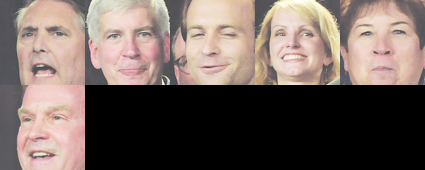

Results found in file a-3.png


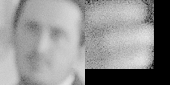

----- RESULTS FOR LARGE IMAGES -----
Results found in file a-0.png


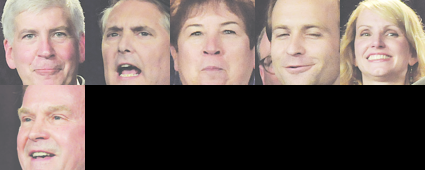

Results found in file a-1.png


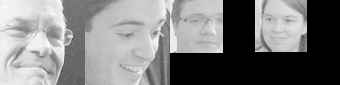

Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png


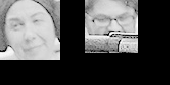

Results found in file a-2.png


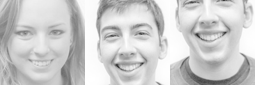

Results found in file a-3.png


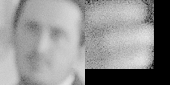

Results found in file a-5.png
But there were no faces in that file!
Results found in file a-8.png
But there were no faces in that file!
Results found in file a-9.png


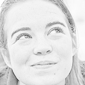

In [3]:
print('----- RESULTS FOR SMALL IMAGES -----')
display_results(dicts_small)
print('----- RESULTS FOR LARGE IMAGES -----')
display_results(dicts_large)